In [1]:
library(dplyr)
library(ape)
library(phytools)
library(RRphylo)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘ape’


The following object is masked from ‘package:dplyr’:

    where


Loading required package: maps

Warning message:
“package ‘RRphylo’ was built under R version 4.3.1”
Loading required package: emmeans


Attaching package: ‘RRphylo’


The following object is masked from ‘package:phytools’:

    node.paths




## Load and prepare data

In [2]:
simplify = function(s){
    v = unlist(strsplit(s, '_'))
    return(paste(v[1], v[2], sep='_'))
}

### BUSCO matrices

In [3]:
wd = "/groups/itay_mayrose_nosnap/liorglic/Projects/intron_evolution/output/species_level_analysis/RESULT_euk_new"

#### Load BUSCO protein lengths matrix and create mask
Based on MAD outliers. This is needed to remove potential errors in orthology assignments.

In [4]:
busco_protein_len_tsv = file.path(wd, 'all_species', 'BUSCO_protein_len.stats')
busco_protein_len_df = read.csv(busco_protein_len_tsv, sep='\t', row.names = 1)
colnames(busco_protein_len_df) = unlist(lapply(colnames(busco_protein_len_df), simplify))

In [5]:
busco_names = rownames(busco_protein_len_df)
mad_outliers = function(v){
    med = median(v, na.rm = TRUE)
    mad = median(abs(v-med), na.rm = TRUE)
    lower = med - 3*mad
    upper = med + 3*mad
    outliers = (v < lower | v > upper)
    names(outliers) = busco_names
    return(outliers)
}

In [6]:
mad_mask = busco_protein_len_df %>% mutate_all(mad_outliers)
mad_mask = as.matrix(mad_mask)

#### Load matrices with gene structure features
Mask each matrix using the MAD mask.

In [7]:
load_busco_matrix = function(busco_tsv){
    busco_df = read.csv(busco_tsv, sep='\t', row.names=1)
    colnames(busco_df) = unlist(lapply(colnames(busco_df), simplify))
    busco_df[mad_mask] = NA
    return(busco_df)
}

In [8]:
# intron content (fraction)
busco_intron_frac_tsv = file.path(wd, 'all_species', 'BUSCO_intron_frac.stats')
busco_intron_frac_df = load_busco_matrix(busco_intron_frac_tsv)
# total intron length
busco_tot_intron_len_tsv = file.path(wd, 'all_species', 'BUSCO_total_intron_len.stats')
busco_tot_intron_len_df = load_busco_matrix(busco_tot_intron_len_tsv)
# total exon length
busco_tot_exon_len_tsv = file.path(wd, 'all_species', 'BUSCO_total_exon_len.stats')
busco_tot_exon_len_df = load_busco_matrix(busco_tot_exon_len_tsv)
# number of introns
busco_n_introns_tsv = file.path(wd, 'all_species', 'BUSCO_n_introns.stats')
busco_n_introns_df = load_busco_matrix(busco_n_introns_tsv)
# intron lengths
busco_intron_lens_tsv = file.path(wd, 'all_species', 'BUSCO_intron_lens.stats')
busco_intron_lens_df = load_busco_matrix(busco_intron_lens_tsv)

#### Calculate species means
Species means across all BUSCOs

In [9]:
calc_sp_means = function(busco_df){
    sp_means = busco_df %>% summarize_all(.funs = mean, na.rm = TRUE) %>% unlist() %>% as.vector()
    names(sp_means) = colnames(busco_df)
    return(sp_means)
}

In [10]:
busco_intron_frac_sp_means_df = calc_sp_means(busco_intron_frac_df)
busco_tot_intron_len_sp_means_df = calc_sp_means(busco_tot_intron_len_df)
busco_tot_exon_len_sp_means_df = calc_sp_means(busco_tot_exon_len_df)
busco_n_introns_sp_means_df = calc_sp_means(busco_n_introns_df)

For intron lengths, we need to do it a bit differently

In [11]:
calc_sp_means_split = function(x){
    return(mean(as.numeric(unlist(strsplit(as.character(x), ','))), na.rm=TRUE))
}

In [12]:
busco_intron_lens_sp_means_df = busco_intron_lens_df %>% summarize_all(.funs = calc_sp_means_split) %>% unlist() %>% as.vector()
names(busco_intron_lens_sp_means_df) = colnames(busco_intron_lens_df)

Combine all species means into one data frame containing all gene structure features

In [13]:
busco_sp_means_df = cbind(busco_intron_frac_sp_means_df, busco_tot_intron_len_sp_means_df, busco_tot_exon_len_sp_means_df, busco_n_introns_sp_means_df, busco_intron_lens_sp_means_df)
colnames(busco_sp_means_df) = c('Mean_intron_content', 'Mean_total_intron_length', 'Mean_total_exon_length', 'Mean_n_introns', 'Mean_intron_length')
busco_sp_means_df = as.data.frame(busco_sp_means_df)

Log10 transformations

In [14]:
log10_transform = function(v){
    log_v = log10(v)
    log_v[is.na(log_v) | is.infinite(log_v)] = 0
    return(log_v)
}

In [15]:
busco_sp_means_df$log_Mean_intron_length = log10_transform(busco_sp_means_df$Mean_intron_length)
busco_sp_means_df$log_Mean_total_exon_length = log10_transform(busco_sp_means_df$Mean_total_exon_length)
busco_sp_means_df$log_Mean_total_intron_length = log10_transform(busco_sp_means_df$Mean_total_intron_length)

### Phylogeny

In [16]:
euk_tree = "../data/ENSEMBL_species_lists/species_clean_nospace.nwk"
euk_tree = read.tree(euk_tree)
euk_tree = di2multi(euk_tree, tol=1)

In [17]:
tips = euk_tree$tip.label
nodes<-sapply(tips,function(x,y) which(y==x),y=euk_tree$tip.label)
## then get the edge lengths for those nodes
edge.lengths<-setNames(euk_tree$edge.length[sapply(nodes,
    function(x,y) which(y==x),y=euk_tree$edge[,2])],names(nodes))

In [18]:
# Remove terminal branches shorter than 1M years
THRESHOLD = 1

tip.label.to.node.num = function(tree,label){
    return(which(tree$tip.label == label))
}

get_tips = function(node){
    tips = names(tip_parents[which(tip_parents == node)])
}

get.branch.len = function(tree, node){
    return(tree$edge.length[which(tree$edge[,2]==node)])
}

terminal_branch_len = c(-Inf)
while (any(terminal_branch_len < THRESHOLD)){
    # find the node numbers at the tips
    tip_node_num = sapply(euk_tree$tip.label, tip.label.to.node.num, tree=euk_tree)
    # find parent nodes of tips
    tip_parents = sapply(tip_node_num, getParent, tree=euk_tree)
    # get the children for each tip parent
    tip_parents = sapply(as.character(unique(tip_parents)), get_tips)
    # get terminal branch lengths
    #terminal_branch_len = sapply(names(tip_parents), get.branch.len, tree=euk_tree)
    terminal_branch_len = setNames(euk_tree$edge.length[sapply(tip_node_num,
    function(x,y) which(y==x),y=euk_tree$edge[,2])],names(tip_node_num))
    to_drop = c()
    for (parent in names(tip_parents)){
        #if (terminal_branch_len[[parent]] < THRESHOLD){
        if (terminal_branch_len[tip_parents[[parent]][1]] < THRESHOLD){
            to_drop = c(to_drop, tip_parents[[parent]][1])
        }
        else if (length(tip_parents[[parent]]) == 2 & terminal_branch_len[tip_parents[[parent]][2]] < THRESHOLD){
            to_drop = c(to_drop, tip_parents[[parent]][2])
        }
    }
    euk_tree = ape::drop.tip(euk_tree, to_drop)
}

### Phylum assignment
Assignment of species to phyla and selecting phyla with >10 species

In [19]:
phylum_tsv = "../output/species_level_analysis/species_euk_phylum.tsv"
phylum_df = read.table(phylum_tsv, sep='\t', header = TRUE)

In [20]:
species_phyla = phylum_df$phylum
names(species_phyla) = phylum_df$species

In [21]:
species_by_phylum = as.data.frame(table(species_phyla))
phyla10 = species_by_phylum[species_by_phylum$Freq >= 10,'species_phyla']
phyla10 = as.character(phyla10)
phyla10

[1] "Arthropoda"   "Ascomycota"   "Chordata"     "Cnidaria"     "Mollusca"    
[6] "Nematoda"     "Streptophyta"

In [22]:
phyla10_species = phylum_df[phylum_df$phylum %in% phyla10, 'species']

In [23]:
# add phylum information to species means df
busco_sp_means_df$species = rownames(busco_sp_means_df)
busco_sp_means_df = left_join(busco_sp_means_df, phylum_df, by='species')
rownames(busco_sp_means_df) = busco_sp_means_df$species

In [24]:
busco_sp_means_phyla10_df = busco_sp_means_df[busco_sp_means_df$phylum %in% phyla10,]

## Modeling gene structure
Based on BUSCO data

### Species means

#### Intron content
Fit a model where the intron content is explained by the total intron and total exon lengths

In [35]:
# Run RRphylo on BUSCO species means intron content
busco_intron_content = busco_sp_means_df$Mean_intron_content
names(busco_intron_content) = rownames(busco_sp_means_df)
busco_intron_content_rrphylo = RRphylo(tree = euk_tree, y = busco_intron_content)

In [36]:
busco_intron_content_sp_means_pgls = PGLS_fossil(modform= Mean_intron_content ~ log_Mean_total_intron_length + log_Mean_total_exon_length, data=busco_sp_means_df, RR=busco_intron_content_rrphylo)
summary(busco_intron_content_sp_means_pgls)


Call:
phylolm::phylolm(formula = modform, data = data, phy = tree, 
    model = model, method = method)

   AIC logLik 
 -2101   1055 

Raw residuals:
     Min       1Q   Median       3Q      Max 
-0.25027 -0.04363  0.22501  0.31178  0.39548 

Mean tip height: 1225.956
Parameter estimate(s) using ML:
sigma2: 1.416589e-05 

Coefficients:
                               Estimate     StdErr t.value   p.value    
(Intercept)                   0.5535394  0.0685078  8.0799 3.876e-15 ***
log_Mean_total_intron_length  0.0887187  0.0065421 13.5613 < 2.2e-16 ***
log_Mean_total_exon_length   -0.1345378  0.0165500 -8.1292 2.696e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.2748	Adjusted R-squared: 0.2722 

__Compare to the model fitted to whole genome data set__

In [37]:
load('intron_content_sp_means_pgls.RData')

In [38]:
summary(intron_content_sp_means_pgls)


Call:
phylolm::phylolm(formula = modform, data = data, phy = tree, 
    model = model, method = method)

   AIC logLik 
 -2117   1062 

Raw residuals:
     Min       1Q   Median       3Q      Max 
-0.29225  0.00981  0.19015  0.26347  0.36382 

Mean tip height: 1174.936
Parameter estimate(s) using ML:
sigma2: 1.205246e-05 

Coefficients:
                                              Estimate     StdErr t.value
(Intercept)                                  0.0617214  0.0495260  1.2462
Mean_total_exon_length_per_transcript_log   -0.0353313  0.0043338 -8.1526
Mean_total_intron_length_per_transcript_log  0.1143764  0.0090240 12.6747
                                              p.value    
(Intercept)                                    0.2132    
Mean_total_exon_length_per_transcript_log   2.268e-15 ***
Mean_total_intron_length_per_transcript_log < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.2197	Adjusted R-squared: 0.217 

In [39]:
busco_intron_content_sp_means_pgls_pred = predict(busco_intron_content_sp_means_pgls)
intron_content_sp_means_pgls_pred = predict(intron_content_sp_means_pgls)

In [40]:
pred_df = as.data.frame(cbind(busco_intron_content_sp_means_pgls_pred, intron_content_sp_means_pgls_pred))

In [41]:
cor(pred_df$busco_intron_content_sp_means_pgls_pred, pred_df$intron_content_sp_means_pgls_pred)**2

[1] 0.781481

__Phylogenetic ANOVA__

In [42]:
busco_intron_content_rescaled_tree = rescaleRR(euk_tree, RR=busco_intron_content_rrphylo)

In [27]:
keep.tip = function(phy, tip){
    all_tips = phy$tip.label
    drop = setdiff(all_tips, tip)
    return(drop.tip(phy,drop))
}

In [44]:
busco_intron_content_rescaled_tree_phyla10 = keep.tip(busco_intron_content_rescaled_tree, phyla10_species)
set.seed(100)
x = busco_sp_means_phyla10_df$phylum
names(x) = rownames(busco_sp_means_phyla10_df)
y = busco_sp_means_phyla10_df$Mean_intron_content
names(y) = rownames(busco_sp_means_phyla10_df)
busco_intron_content_sp_means_phyl_anova = phylANOVA(busco_intron_content_rescaled_tree_phyla10, x, y)
busco_intron_content_sp_means_phyl_anova

ANOVA table: Phylogenetic ANOVA

Response: y
            Sum Sq  Mean Sq    F value Pr(>F)
x        24.367593 4.061265 230.393634  0.082
Residual  9.078166 0.017628                  

P-value based on simulation.
---------

Pairwise posthoc test using method = "holm"

Pairwise t-values:
             Arthropoda Ascomycota   Chordata   Cnidaria   Mollusca  Nematoda
Arthropoda     0.000000  12.950035 -25.085590  -5.697389  -9.091334 -0.231444
Ascomycota   -12.950035   0.000000 -31.242087 -12.075096 -15.469778 -6.952369
Chordata      25.085590  31.242087   0.000000   3.117426   0.036439  8.719873
Cnidaria       5.697389  12.075096  -3.117426   0.000000  -2.275217  4.039982
Mollusca       9.091334  15.469778  -0.036439   2.275217   0.000000  6.410270
Nematoda       0.231444   6.952369  -8.719873  -4.039982  -6.410270  0.000000
Streptophyta  10.212151  20.366765 -11.806685  -1.304550  -4.477640  4.121555
             Streptophyta
Arthropoda     -10.212151
Ascomycota     -20.366765
Chordata  

#### Total intron length
Total intron length ~ Mean intron length * Mean number of introns

In [45]:
busco_tot_intron_length = busco_sp_means_df$log_Mean_total_intron_length
names(busco_tot_intron_length) = rownames(busco_sp_means_df)
busco_tot_intron_length_rrphylo = RRphylo(tree = euk_tree, y = busco_tot_intron_length)

In [46]:
busco_tot_intron_length_sp_means_pgls = PGLS_fossil(modform=  log_Mean_total_intron_length ~ log_Mean_intron_length * Mean_n_introns, data=busco_sp_means_df, RR=busco_tot_intron_length_rrphylo)
summary(busco_tot_intron_length_sp_means_pgls)


Call:
phylolm::phylolm(formula = modform, data = data, phy = tree, 
    model = model, method = method)

   AIC logLik 
 -2168   1089 

Raw residuals:
     Min       1Q   Median       3Q      Max 
-2.46463  0.06565  0.08682  0.10456  0.14649 

Mean tip height: 1275.673
Parameter estimate(s) using ML:
sigma2: 1.454429e-05 

Coefficients:
                                        Estimate     StdErr t.value   p.value
(Intercept)                           -0.1464948  0.0793444 -1.8463   0.06536
log_Mean_intron_length                 1.1553566  0.0235307 49.0999 < 2.2e-16
Mean_n_introns                         0.1364115  0.0098458 13.8547 < 2.2e-16
log_Mean_intron_length:Mean_n_introns -0.0250989  0.0032963 -7.6142 1.108e-13
                                         
(Intercept)                           .  
log_Mean_intron_length                ***
Mean_n_introns                        ***
log_Mean_intron_length:Mean_n_introns ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1

In [47]:
# Mean intron length partial R^2
summary(PGLS_fossil(modform=  log_Mean_total_intron_length ~ log_Mean_intron_length, data=busco_sp_means_df, RR=busco_tot_intron_length_rrphylo))$adj.r.squared

[1] 0.751252

In [48]:
# Mean number of introns partial R^2
summary(PGLS_fossil(modform=  log_Mean_total_intron_length ~ Mean_n_introns, data=busco_sp_means_df, RR=busco_tot_intron_length_rrphylo))$adj.r.squared

[1] 0.1027803

### Per BUSCO
Analyze gene structure evolution per BUSCO

In [86]:
analyze_busco = function(busco_df, busco_id){
    busco_data = as.numeric(busco_df[busco_id,])
    names(busco_data) = colnames(busco_df)
    busco_data = busco_data[!is.na(busco_data)]
    if (length(busco_data) < 50){
        return(NA)
    }
    busco_tree = keep.tip(euk_tree, names(busco_data))
    rrphylo = RRphylo(tree = busco_tree, y = busco_data)
    rescaled_tree = rescaleRR(busco_tree, RR=rrphylo)
    # subset tree and data for phyla with >10 species
    rescaled_tree_phyla10 = keep.tip(rescaled_tree, phyla10_species)
    busco_data_phyla10 = busco_data[rescaled_tree_phyla10$tip.label]
    # phylogenetic ANOVA
    set.seed(100)
    x = species_phyla[names(busco_data_phyla10)]
    y = busco_data_phyla10
    phyl_anova = phylANOVA(rescaled_tree_phyla10, x, y) 
    return (list(data=busco_data, rrphylo=rrphylo, phyl_ANOVA=phyl_anova))
}

In [1]:
load('per_buscp_analysis_res.RData')

In [69]:
busco_intron_frac_df['1001705at2759', c('brassica_napus','brassica_juncea')]

,brassica_napus,brassica_juncea
,<dbl>,<dbl>
1001705at2759,0.228,0.213


In [64]:
tmp_tree = per_buscp_analysis_res$`1001705at2759`$rrphylo$tree
tmp_tree$node.label = per_buscp_analysis_res$`1001705at2759`$rrphylo$aces[,1]

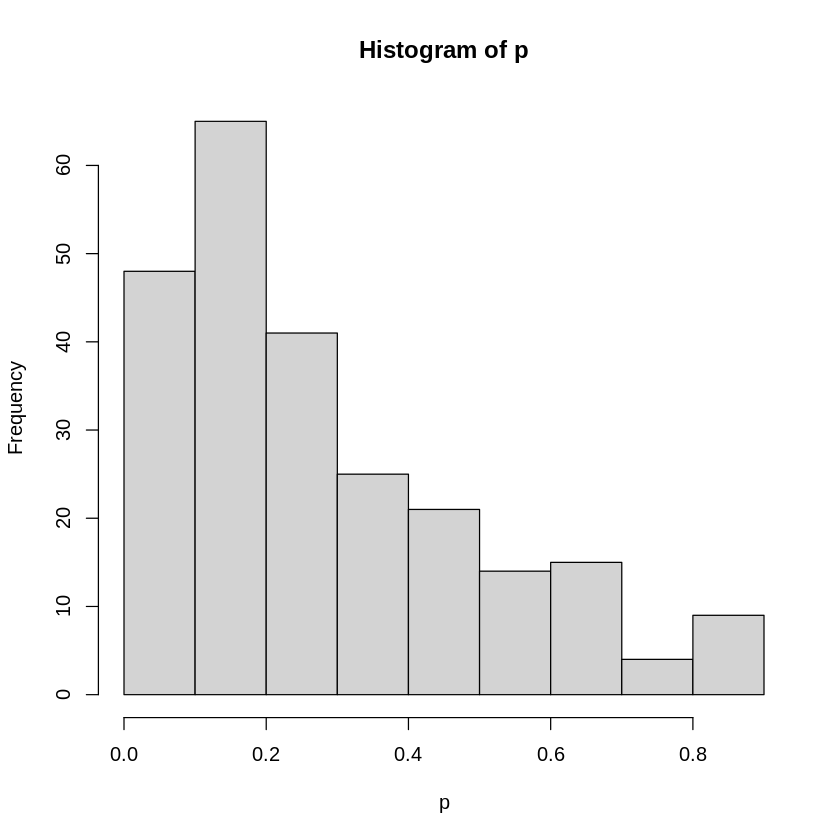

In [51]:
p = c()
for (busco_id in rownames(busco_intron_frac_df)){
    if (length(per_buscp_analysis_res[[busco_id]]) == 1){
        next
    }
    p = c(p, per_buscp_analysis_res[[busco_id]]$phyl_ANOVA$Pf)
}
hist(p)

In [54]:
p[p<0.05]*255

[1]  7.395  1.530  7.905  4.335  3.060 11.730  8.925  5.355 11.730  5.100
[11] 11.730  8.415  4.590 11.730  0.255  7.140 11.985  1.530

In [45]:
all_subtrees = subtrees(euk_tree)
for (tree in all_subtrees){
    tree_age = max(node.depth.edgelength(tree))
    if (length(tree$tip.label) >= 30 & tree_age >= 396 & tree_age <= 397){
        print(tree_age)
        print(tree$tip.label)
    }
}

[1] 396.3505
 [1] "lepisosteus_oculatus"          "esox_lucius"                  
 [3] "oncorhynchus_mykiss"           "oncorhynchus_tshawytscha"     
 [5] "oncorhynchus_kisutch"          "salmo_salar"                  
 [7] "hucho_hucho"                   "sparus_aurata"                
 [9] "mola_mola"                     "tetraodon_nigroviridis"       
[11] "takifugu_rubripes"             "larimichthys_crocea"          
[13] "dicentrarchus_labrax"          "labrus_bergylta"              
[15] "sander_lucioperca"             "cyclopterus_lumpus"           
[17] "gasterosteus_aculeatus"        "cottoperca_gobio"             
[19] "betta_splendens"               "anabas_testudineus"           
[21] "mastacembelus_armatus"         "monopterus_albus"             
[23] "lates_calcarifer"              "scophthalmus_maximus"         
[25] "cynoglossus_semilaevis"        "seriola_dumerili"             
[27] "seriola_lalandi"               "echeneis_naucrates"           
[29] "amphilophus_cit